# Imports

In [1]:
import psycopg2 as pg
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display       import Image

In [9]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

# 1 Coleta dos Dados

In [19]:
# Credenciais
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

In [20]:
conn = pg.connect(user = username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

OperationalError: could not translate host name "comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com" to address: Name or service not known


## 1.1 Consulta do Schema

In [ ]:
cursor = conn.cursor()

query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute(query_schema)

record = cursor.fetchall()
cursor.close()
conn.close()

In [ ]:
record

## 1.2 Consulta das Tabelas

In [ ]:
cursor = conn.cursor()

query_table = """
select tablename
from pg_catalog.pg_tables pt 
where  schemaname = 'pa004'
"""

cursor.execute(query_table)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

## 1.3 Coleta de Dados usando o Psycopg2

In [ ]:
cursor = conn.cursor()

query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

cursor.execute(query)
record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

In [ ]:
pd.DataFrame(record)

## 1.4 Coleta de Dados usando Pandas

In [ ]:
query = """
SELECT
*
FROM pa004.users u
WHERE u.age > 44
LIMIT 10
"""

pd.read_sql(query, conn)

In [ ]:
query = """
SELECT
*
FROM pa004.users u LEFT JOIN pa004.vehicle v ON (u.id = v.id)
                   LEFT JOIN pa004.insurance i ON (u.id = i.id)
"""

df = pd.read_sql(query, conn)
df.head()

In [ ]:
# Drop das Colunas "id" que estão repetidas
df['id_aux'] = df['id'].apply(np.mean, axis=1)
df = df.drop(columns='id', axis=1)

df.insert(0, 'id', df['id_aux'].astype('int64')) 
df = df.drop(columns='id_aux', axis=1)

In [ ]:
df.head()

In [ ]:
df.to_csv('datasets/data_raw.csv', index=False)

# 2 Análise Descritiva

In [3]:
df2 = pd.read_csv('datasets/data_raw.csv')

In [30]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,13,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,18,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,31,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,39,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


## 2.1 Dimensões dos dados

In [ ]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

## 2.2 Tipos das Variáveis

In [ ]:
df2.dtypes

## 2.3 Checagem de NA's

In [ ]:
df2.isna().sum()

## 2.4 Estatística Descritiva

In [ ]:
df2.describe()

In [ ]:
df2_cat = df2.select_dtypes(include=['object'])
df2_cat.head()

In [ ]:
# gender x response
df_aux = df[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='gender', y='frequencia', hue='response');

In [ ]:
# vehicle_age x response
df_aux = df[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_age', y='frequencia', hue='response')

In [ ]:
# vehicle_damage x response
df_aux = df[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_damage', y='frequencia',hue='response')

# 3 Feature Engineering

In [4]:
df3 = df2.copy()

## 3.1 Mapa Mental de Hipóteses

In [ ]:
Image('images/Seguro_de_Vida.png')

## 3.2 Criação de Hipóteses

### 3.2.1 Clientes

**H1**: Clientes mais velhos tem mais interesse em obter seguro de automóvel.

**H2**: Clientes mulheres tem mais interesse em obter seguro de automóvel.

**H3**: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

**H4**: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

**H5**: Clientes mais antigos possuem mais interesse em obter seguro de automóivel.

### 3.2.2 Veículo

**H6**: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.

**H7**: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.

**H8**: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.

**H9**: Clientes que usam o carro para trabalhar possuem mais interesse em obter seguro de automóvel.

### 3.2.3 Localização

Nesse ciclo não temos grandes informações sobre as localizações dos clientes, então não serão expĺoradas hipóteses de negócios para esse atributo. Mas, algumas hipóteses que poderiam ser levantadas, seriam:

**H10**: Clientes que moram na zona urbana possuem mais interesse em obter seguro de automóvel.

**H11**: Clientes que moram em área periféricas possuem menos interesse em obter seguro de automóvel.

**H12**: Clientes que moram em área perto a escolas possuem mais interesse em obter seguro de automóvel.

## 3.3 Feature Engineering

In [5]:
# gender
df3['gender'] = df3['gender'].apply(lambda x: '0' if x == 'Male' else '1')

# vehicle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 0.5 if x == '< 1 Year' else 
                                                        1.5 if x == '1-2 Year' else
                                                        2.5)

# vehicle damage
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
df3.head()

# 4 Análise Exploratória dos Dados


Referências para gráficos: 
https://www.python-graph-gallery.com/
https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot

In [6]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

<AxesSubplot:xlabel='response', ylabel='id'>

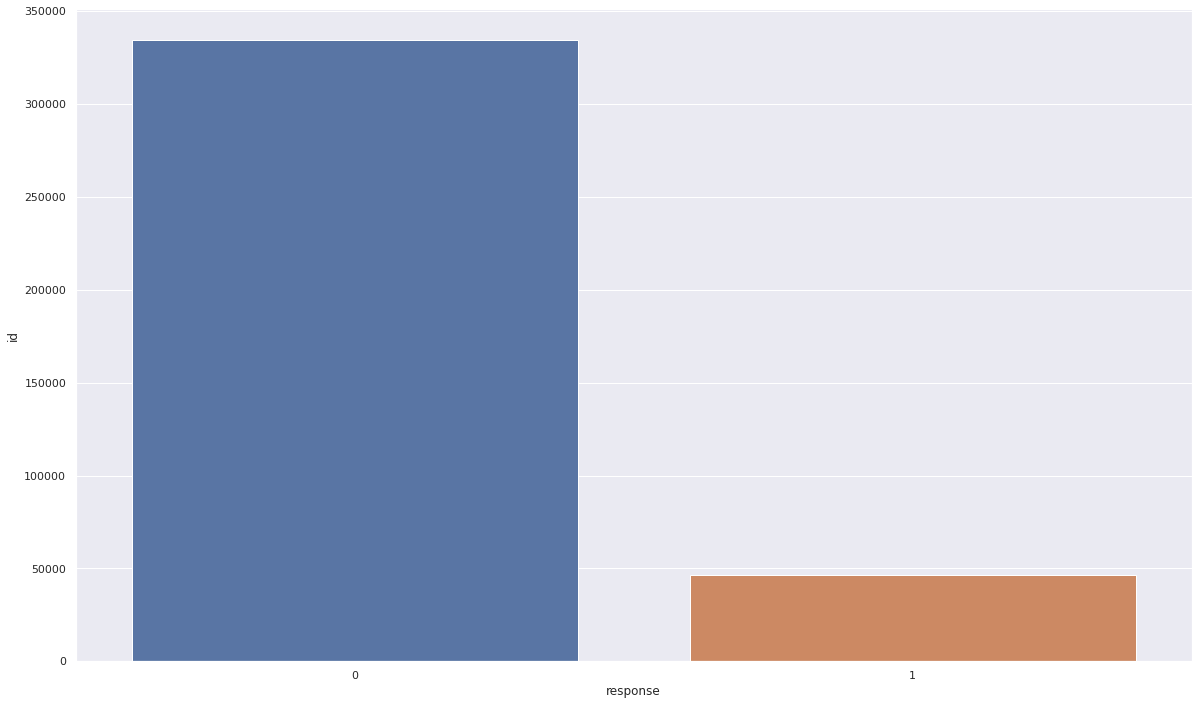

In [10]:
df_aux = df4[['id','response']].groupby('response').count().reset_index()

sns.barplot(data=df_aux, x='response', y='id')

### 4.1.2 Variáveis Numéricas

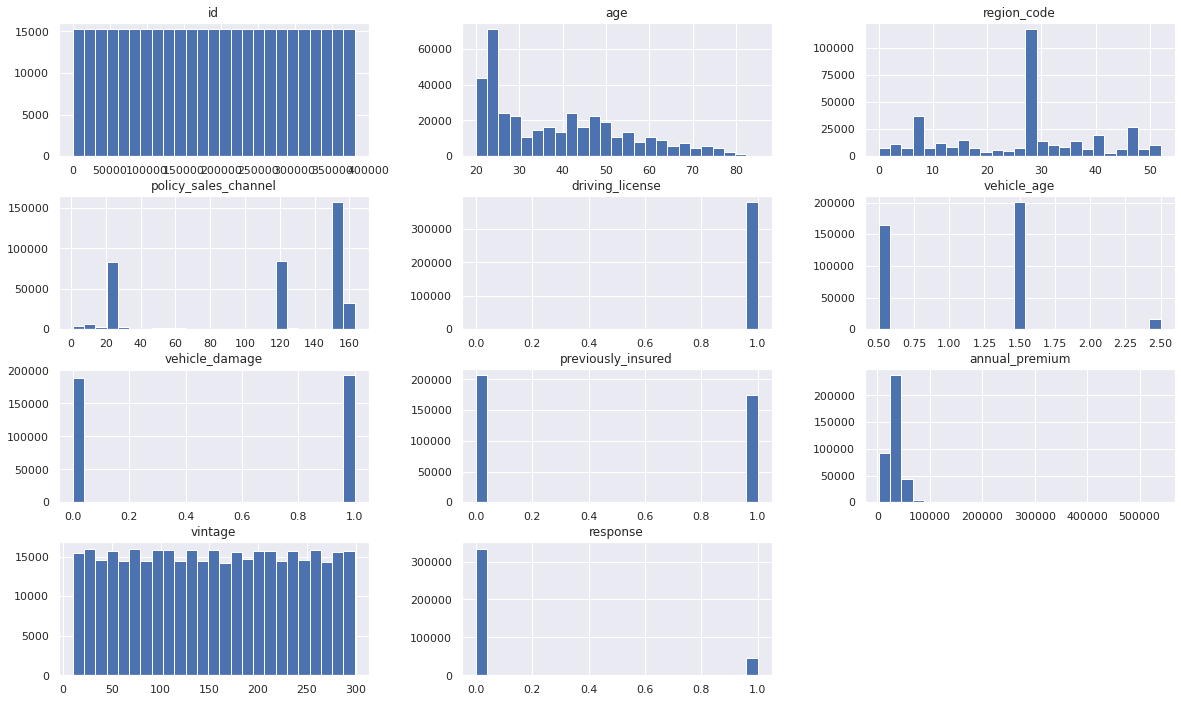

In [11]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])

df4_num.hist(bins=25);

## 4.2 Análise Bivariada

### 4.2.1 H1: Clientes mais velhos tem mais interesse em obter seguro de automóvel.
Falso. Clientes na meia idade (entre 30 e 50 anos) possuem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='age', ylabel='response'>

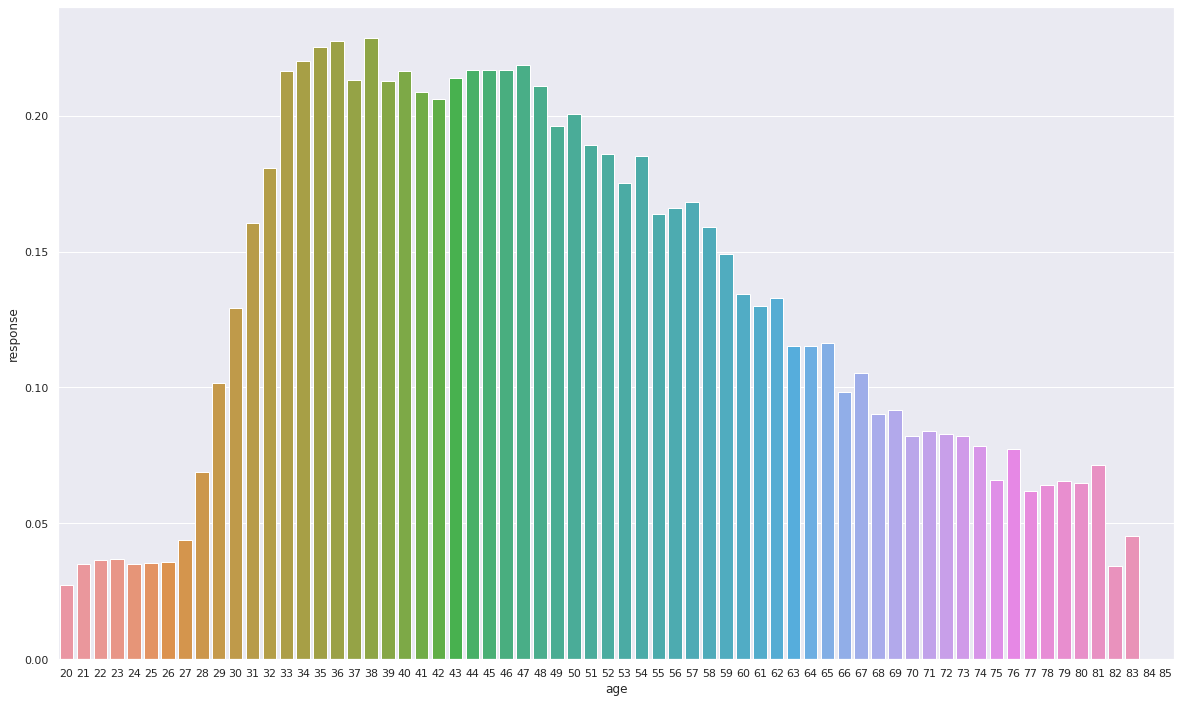

In [25]:
# age x response
df_aux = df4[['age', 'response']].groupby('age').mean().reset_index()

sns.barplot(data=df_aux, x='age', y='response')

### 4.2.2 H2: Clientes mulheres tem mais interesse em obter seguro de automóvel.
Falso. Clientes mulheres tem menos interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='gender', ylabel='response'>

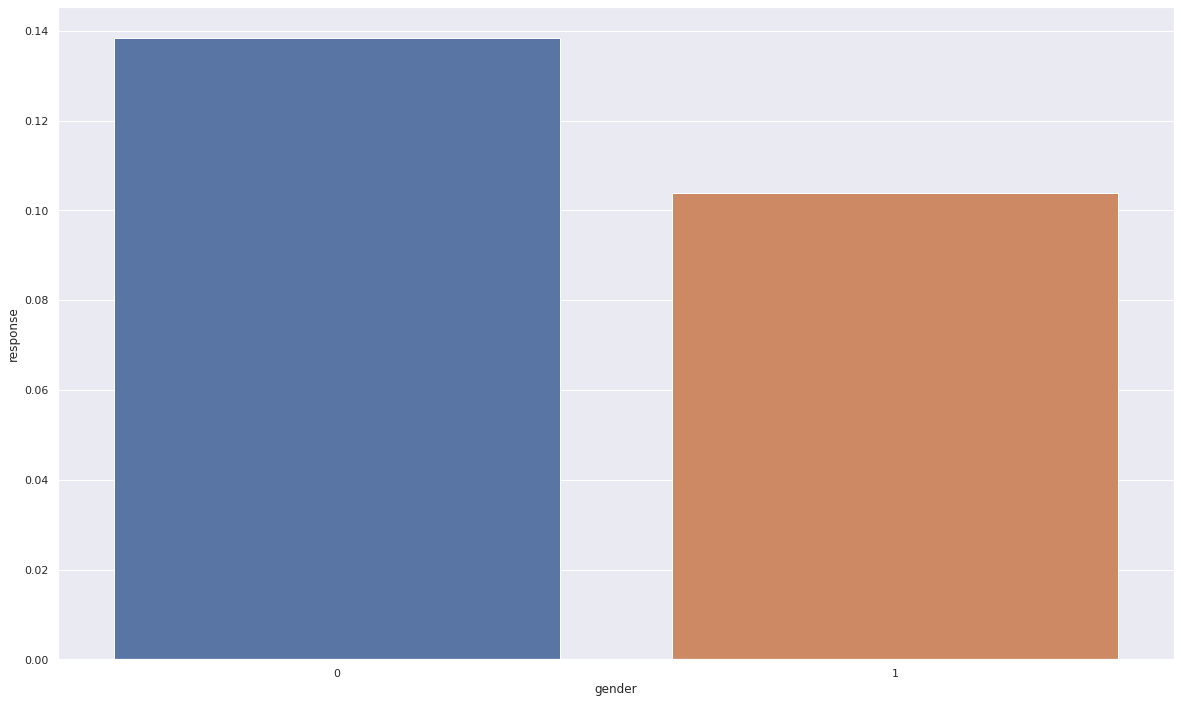

In [24]:
# gender x response
df_aux = df4[['gender', 'response']].groupby('gender').mean().reset_index()

sns.barplot(data=df_aux, x='gender', y='response')

### 4.2.3 H3: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.
Verdadeiro. Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

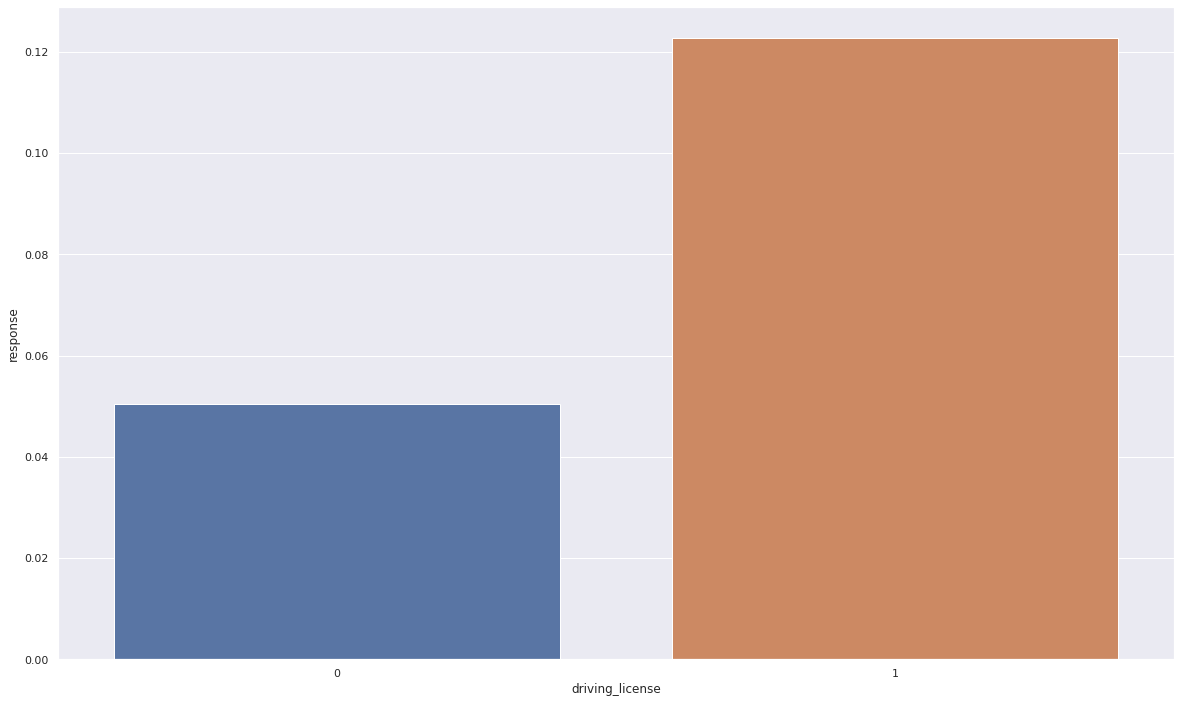

In [23]:
# driving_license x response
df_aux = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()

sns.barplot(data=df_aux, x='driving_license', y='response')

### 4.2.4 H4: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

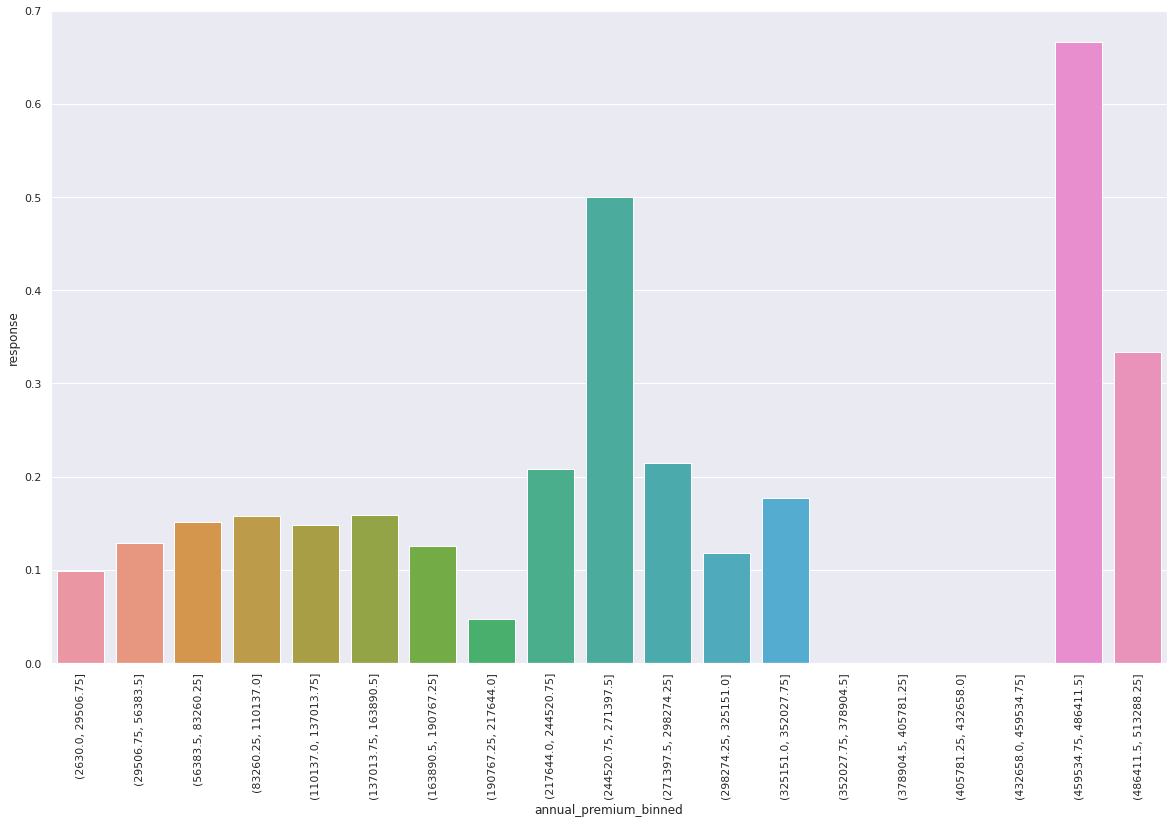

In [22]:
# annual_premium x response
# df_aux = df4[['annual_premium', 'response']].groupby('annual_premium').count().reset_index()

x0 = df4['annual_premium'].min()
xf = df4['annual_premium'].max()

b = list(np.arange(x0, xf, (xf-x0)/20))
df4['annual_premium_binned'] = pd.cut(df4['annual_premium'], bins=b)
df_aux = df4[['annual_premium_binned', 'response']].groupby('annual_premium_binned').mean().reset_index()

sns.barplot(data=df_aux, x='annual_premium_binned', y='response');
plt.xticks(rotation=90);

### 4.2.5 H5: Clientes mais antigos possuem mais interesse em obter seguro de automóvel.
**Falso** Não há diferença significativa com relação ao tempo que o cliente possui o seguro de vida.

<AxesSubplot:xlabel='response', ylabel='vintage_binned'>

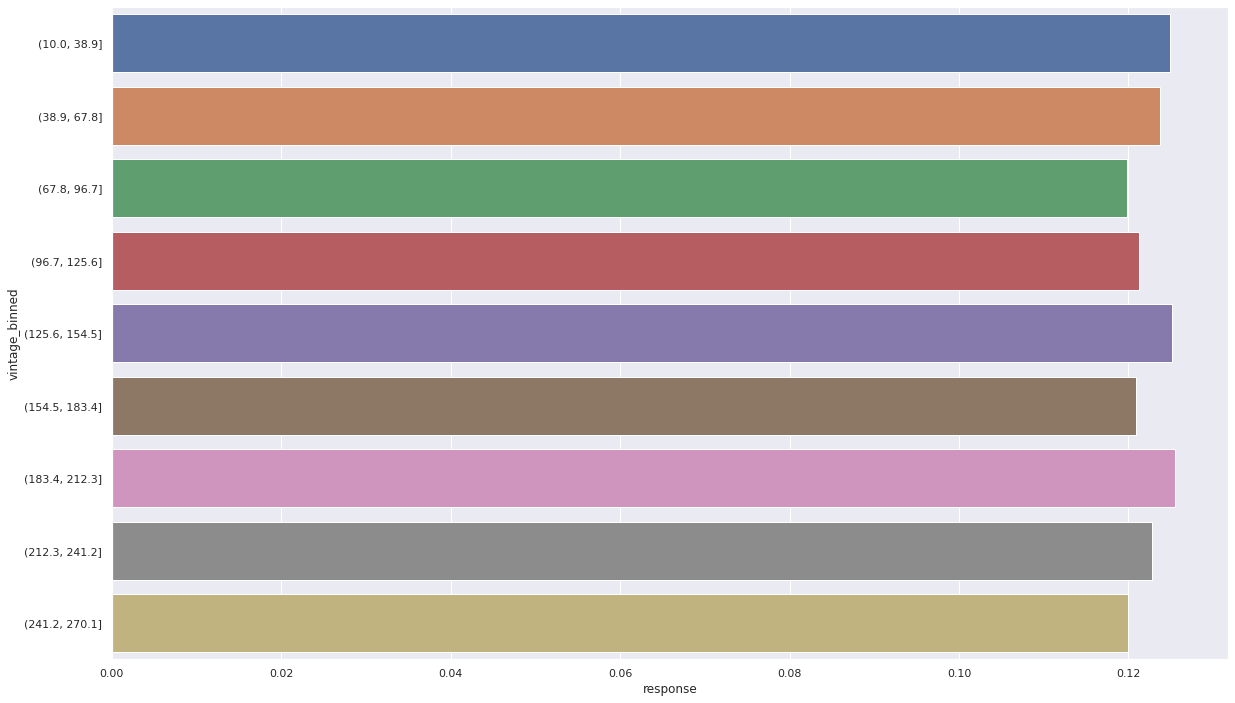

In [39]:
# vintage x response

x0 = df4['vintage'].min()
xf = df4['vintage'].max()

b = list(np.arange(x0, xf, (xf-x0)/10))
df4['vintage_binned'] = pd.cut(df4['vintage'], b)
aux = df4[['vintage_binned', 'response']].groupby('vintage_binned').mean().reset_index()

sns.barplot(data=aux, y='vintage_binned', x='response')


### 4.2.6 H6: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.
**Falso** Clientes com veículos mais antigos tem mais interesse em obter seguro de automóvel

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

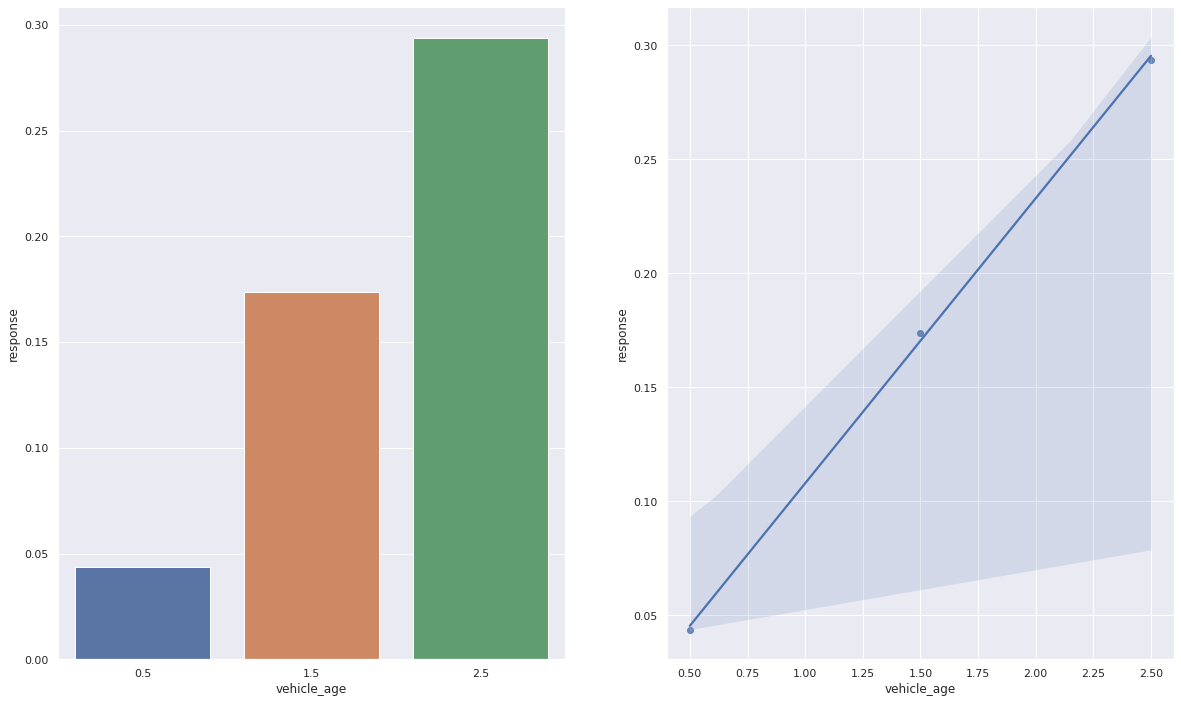

In [41]:
# vehicle_age x response
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux, x='vehicle_age', y='response')

plt.subplot(1, 2, 2)
sns.regplot(data=aux, x='vehicle_age', y='response')

### 4.2.7 H7: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.
**Verdade** Clientes com veículos que já foram danificados tem MUITO mais interesse em obter seguro de automóvel.


<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

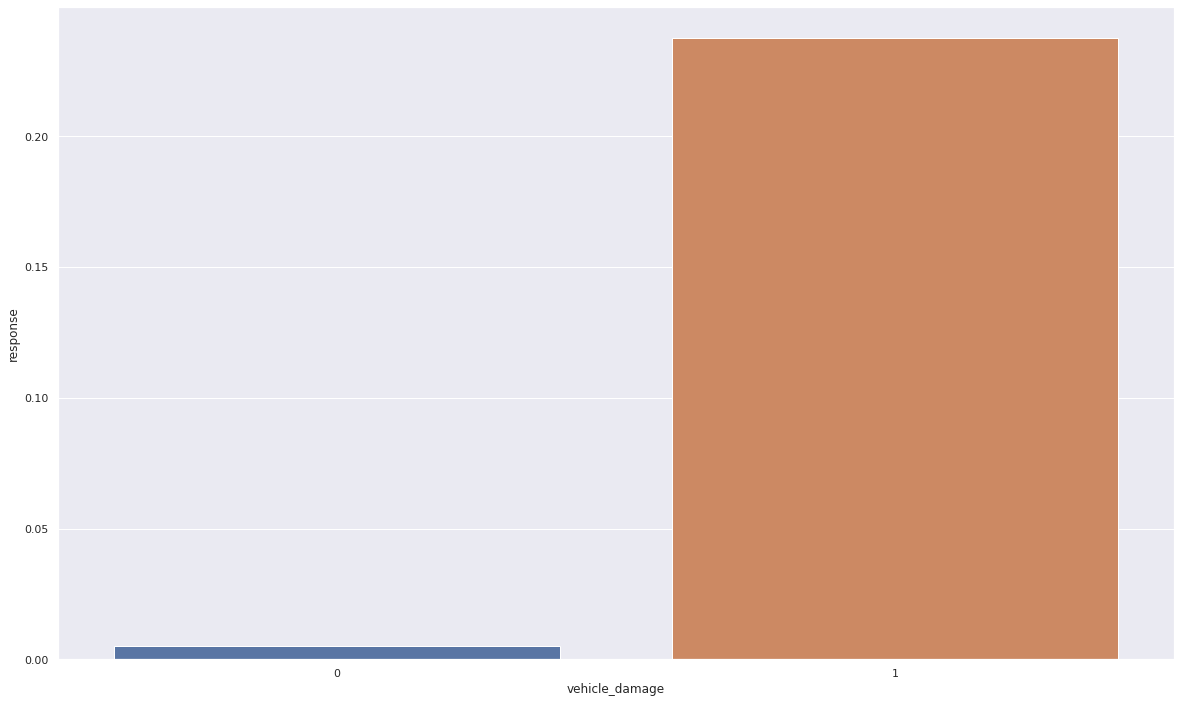

In [47]:
# vehicle_damage x response
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()

sns.barplot(data=aux, x='vehicle_damage', y='response')

### 4.2.8 H8: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.
**Verdade** Clientes que já possuem seguro de automóvel em outra seguradora possuem EXTREMAMENTE MENOS interesse em obter um novo seguro.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

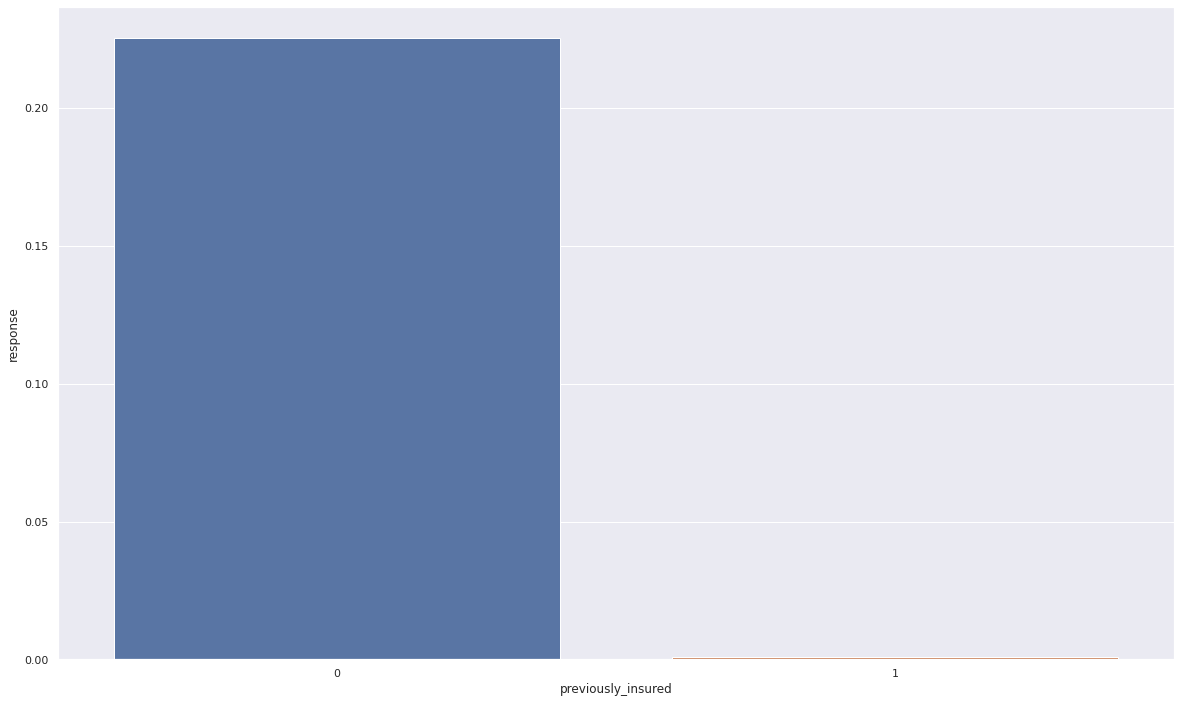

In [50]:
# previously_insured x response
aux = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()

sns.barplot(data=aux, x='previously_insured', y='response')

# 5 Seleção dos Atributos